# 检测框

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

In [2]:
# 解决内核挂掉的问题
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

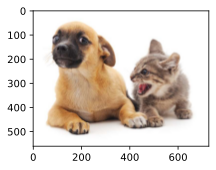

In [3]:
d2l.set_figsize()
img = d2l.plt.imread('./img/catdog.jpg')
d2l.plt.imshow(img)

In [8]:
def box_corner_to_center(boxes):
    '''
    从（左上、右下）转换到（中间、宽度、高度）
    '''
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx,cy,w,h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    '''
    从（中间、宽度、高度）转换到（左上、右下）
    '''
    cx, cy, w, h = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1,y1,x2,y2), axis=-1)
    return boxes

In [9]:
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 450.0]

boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

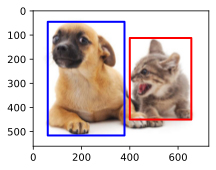

In [10]:
def bbox_to_rect(bbox, color):
    return d2l.plt.Rectangle(xy=(bbox[0], bbox[1]),
                            width=bbox[2]-bbox[0],
                            height=bbox[3]-bbox[1],
                            fill=False,
                            edgecolor=color,
                            linewidth=2)

fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue')) # add_patch为图像添加补丁
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red')) # 为图像添加补丁

# 目标检测数据集
收集并标记了一个小型数据集，下载数据集

In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [2]:
# 解决内核挂掉的问题
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
d2l.DATA_HUB['banana-detection'] = (
d2l.DATA_URL + 'banana-detection.zip',
'5de26c8fce5ccdea9f91267273464dc968d20d72')

In [4]:
def read_data_bananas(is_train=True):
    '''
    读取香蕉检测数据集中的图像和标签
    '''
#     data_dir = d2l.download_extract('banana-detection') # 首次下载运行这一行
    data_dir = './img/banana-detection/'  # 下载后我们将文件存放在img文件中并解压
    print(data_dir)
    csv_fname = os.path.join(data_dir, 
                            'bananas_train' if is_train else 'bananas_val',
                            'label.csv')
    print(csv_fname)
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(
            torchvision.io.read_image(
                os.path.join(data_dir,
                    'bananas_train' if is_train else 'bananas_val',
                    'images', f'{img_name}')))
        targets.append(list(target))
        
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [5]:
class BananasDataset(torch.utils.data.Dataset):
    '''
    一个用于加载香蕉检测数据集的自定义数据集
    '''
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read' + str(len(self.features)) + (
            f' training examples' if is_train else f' validation examples'))
    
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])
    
    def __len__(self):
        return len(self.features)

In [6]:
def load_data_bananas(batch_size):
    '''
    加载香蕉检测数据集
    '''
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                            batch_size,
                                            shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                          batch_size,
                                          shuffle=False)
    return train_iter, val_iter

In [7]:
# 读取一个小批量，并打印其中的图像和标签的形状
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

./img/banana-detection/
./img/banana-detection/bananas_train\label.csv
read1000 training examples
./img/banana-detection/
./img/banana-detection/bananas_val\label.csv
read100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

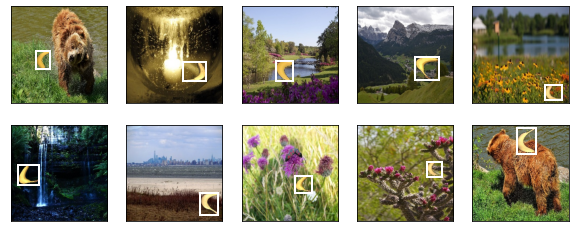

In [8]:
# 示范
imgs = (batch[0][0:10].permute(0,2,3,1))/255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5]*edge_size], colors=['w'])